#  IV-curve modeling

<table>
  <tr>
    <td><img src="https://raw.githubusercontent.com/AlexandreHugoMathieu/pvfault_detection_solar_academy/refs/heads/master/notebooks/logos/CSTB_logo.jpg" width="200" />
    <td><img src="https://raw.githubusercontent.com/AlexandreHugoMathieu/pvfault_detection_solar_academy/refs/heads/master/notebooks/logos/Heliocity_logo.png" width="200" /> 
    <td><img src="https://raw.githubusercontent.com/AlexandreHugoMathieu/pvfault_detection_solar_academy/refs/heads/master/notebooks/logos/USMB_logo_horizontal.png" width="200" />
  </tr>
</table>

<sub>Author: Alexandre MATHIEU, Phd Student, in collaboration Heliocity / CSTB / USMB (LOCIE). </sub>
<sub>Phd thesis: Methodology development to guarantee building photovoltaic systems' performance including failure modelling</sub>

This notebook introduces some tools to estimate the IV-curve at the array level to get the maximum power point.

It is broken down into two parts:

1. **IV curve modeling**: Estimates IV-curve at the module level and, then at the array level
2. **DC power estimation**: DC power estimation with IV curves and comparison to real values.

Some extra commands are introduced in the introduction of this notebook.

**Make sure to manually execute the cells (ctrl + enter) yourself one by one**

To generate an IV curve, the following parameters are needed for the DeSoto 1-diode 5-parameter model:

- Photocurrent ($I_L$): The current generated by the PV module due to light exposure, which is typically proportional to the solar irradiance.

- Saturation Current ($I_0$): The dark saturation current of the diode, which represents the recombination losses in the PV cell.

- Series Resistance ($R_s$): The resistance in series, representing the internal resistance of the PV cell and the connections.

- Shunt Resistance ($R_{sh}$): The resistance in parallel, which accounts for leakage currents in the PV cell.

- The modified Diode Ideality Factor ($a$): product of the diode ideality factor, number of cells and cell thermal voltage.

The Single Diode model Equation:

 $$I = I_L - I_0 \cdot (exp(\frac{V + I \cdot R_s}{a}) - 1) - \frac{V+ I \cdot  R_s}{R_{sh}} $$ 

Reference: W. De Soto, S.A. Klein, W.A. Beckman, Improvement and validation of a model for photovoltaic array performance, Solar Energy, Volume 80, Issue 1, 2006

# 0. Extra commands

This section introduces few commands useful for the notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate V from a list of current I with the deSoto model
from pvlib.pvsystem import v_from_i
from tqdm import tqdm
from scipy.optimize import curve_fit # to perform regression

# Some warnings appear when calculating the IV-curve because of wrong inputs within a logarithm
# Those two lines, avoid to print the warnings
import warnings
warnings.filterwarnings("ignore")

#### Create and manipulate List / np.array

In [2]:
# Create a list of values starting from -5 to 20 with a step 2
v_index= np.arange(-5, 20, 2) 
print(v_index)

i_index = 10 - v_index
print(i_index)

[-5 -3 -1  1  3  5  7  9 11 13 15 17 19]
[15 13 11  9  7  5  3  1 -1 -3 -5 -7 -9]


In [3]:
# To create a loop over 5 iterations:
for i in range(5):
    print(i)

0
1
2
3
4


In [4]:
# Tqdm enable to see the progress when doing loops, you might need to indicate the total number of elements to go through with the argument "total"
for i in tqdm(range(10000000), total=len(range(10000000))):
    _

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000000/10000000 [00:02<00:00, 4212754.18it/s]


#### Plots commands

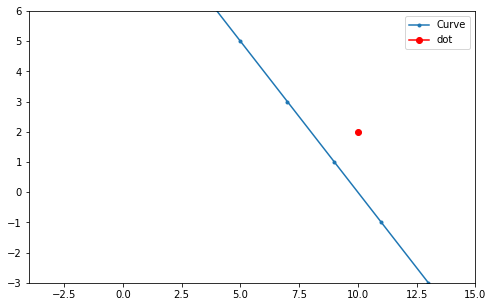

In [5]:
# Store values with a DataFrame
iv_df = pd.DataFrame()
iv_df["i"] = i_index
iv_df["v"] = v_index

# Create a new figure with plt.subplots
fig, ax = plt.subplots(1,1, figsize=(8,5)) 

plt.plot(iv_df["v"], iv_df["i"], marker=".", label="Curve")
plt.plot(10, 2, color="red", marker="o", label="dot") # Plot one dot in red

plt.ylim([-3, 6]) # Scale Y axis between -3 and 6
plt.xlim([-4, 15]) # Scale X axis between -4 and 15

plt.legend() # Show the labels

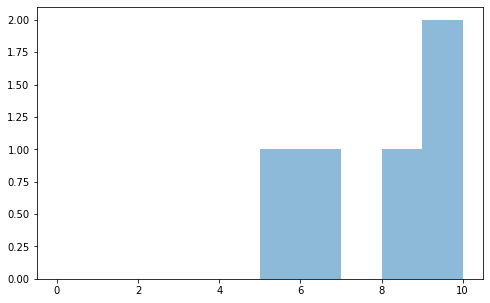

In [6]:
# plot an histogram, ie how many values there are per bins
dummy_list = [10,5,6,10,8]

fig, ax = plt.subplots(1,1, figsize=(8,5)) 

# Alpha is the "transparency" of the bars
# bins define the limits of the bins in which the number of values are counted up
_ = plt.hist(dummy_list, alpha=0.5, bins=np.arange(0,11,1))

#### Get maximums in a DataFrame

In [7]:
print(iv_df["v"].max())
print(iv_df["v"].idxmax())

print("\n DataFrame") # ''\n': enables to return to the line
print(iv_df)

print("\n Row")
idx = iv_df["v"].idxmax()
print(iv_df.loc[idx])

19
12

 DataFrame
     i   v
0   15  -5
1   13  -3
2   11  -1
3    9   1
4    7   3
5    5   5
6    3   7
7    1   9
8   -1  11
9   -3  13
10  -5  15
11  -7  17
12  -9  19

 Row
i    -9
v    19
Name: 12, dtype: int32


## I. IV curve modeling

IV curves are estimated at the array level in this section.

In [8]:
k =  8.617333262e-05 # Boltzmann constant [eV]

# STC 5-parameters
I_L_ref= 6.041432734377855 # A 
I_o_ref=  7.978171413949759e-13 # A
R_s= 0.8019879393203573 # Ohm
R_sh_ref= 422.9947763950826 # Ohm
a_ref= 2.3491351509996625 # V

# Thermal coefficient: short-circuit current
alpha_sc= 0.00332 # A / °C

### Exercice: Five parameters / Single Diode model

Calculates the five parameters for the single diode model for:
- 800 W / m²
- 40 °C

In [9]:
# Calculates five parameter values for the single diode equation at effective irradiance and cell temperature using the DeSoto model.
from pvlib.pvsystem import calcparams_desoto
i_l, i_0, r_s, r_sh, a = calcparams_desoto(800, 40,  alpha_sc, a_ref, I_L_ref, I_o_ref, R_sh_ref, R_s)
print(i_l, i_0, r_s, r_sh, a)

4.872986187502285 8.829904736330836e-12 0.8019879393203573 528.7434704938532 2.467320719555741


### Exercice: IV-curve at the module level

Estimate the IV-curve for the following conditions:
- 800 W / m²
- 40 °C

Store the results in a DataFrame.

**Follow the steps:**

1. Create a list of current ranging from -1A to 10A with a step of 0.0001 according to the function from numpy "range".

2. Calculate the current according to the function from "v_from_i". 

3. Store the values in a DataFrame with two columns ["v","i"] for voltage and current respectively.

*Hints:*

The function "v_from_i" from pvlib come in handy. It enables to calculate the voltage values from the current. Check it out!  https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.pvsystem.v_from_i.html#pvlib.pvsystem.v_from_i.

Notice that "v_from_i" can directly take a list as input for the "current" argument. 



**Be careful: the DeSoto model does not estimate correctly the negative-voltage quadrant**

In [10]:
# Prepare the voltage range
i_range = np.arange(-1, 10, 0.0001)
v_range = v_from_i(i_range, i_l, i_0, r_s, r_sh,a)

# Store the values
iv_df = pd.DataFrame()
iv_df["i"] = i_range
iv_df["v"] = v_range

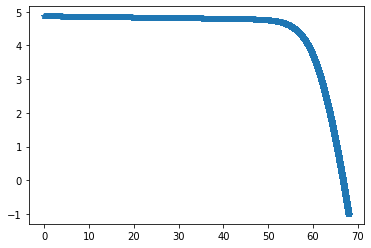

In [11]:
filter = iv_df["v"]>0 
plt.plot(iv_df.loc[filter, "v"], iv_df.loc[filter,"i"], marker="*")

### Exercice: IV-curve util functions

- Create a function to extract the maximum power from an IV-curve.

- Plot the current I as function of the voltage V and show the maximum point point on the curve (only on the positive quadrant !).

- Plot the power P as function of the voltage V and show the maximum point point on the curve (only on the positive quadrant !).

In [12]:
def get_ivmax(curve):
    """Get P, I, V which maximize the power"""
    
    curve["p"] = curve["v"] * curve["i"]
    Pmax = curve["p"].max()
    idxmax= curve['p'].idxmax()
    I_max, V_max =  curve.loc[idxmax, ["i", "v"]].values
    
    return Pmax, I_max, V_max

In [13]:
p_max, i_max, v_max = get_ivmax(iv_df)
print(p_max, i_max, v_max)

251.69650463775363 4.548899999999389 55.33128990256709


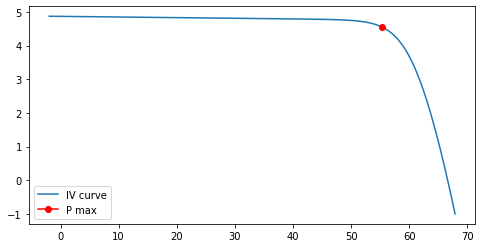

In [14]:
def plot_iv_curve_m(iv_df):
    p_max, i_max, v_max = get_ivmax(iv_df)
    
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    filter = (iv_df["v"]>-2)
    plt.plot(iv_df.loc[filter, "v"], iv_df.loc[filter,"i"], label="IV curve")
    plt.plot(v_max, i_max, color="red", marker="o", label="P max")
    plt.legend() # Show the labels
    
    return ax

_ = plot_iv_curve_m(iv_df)

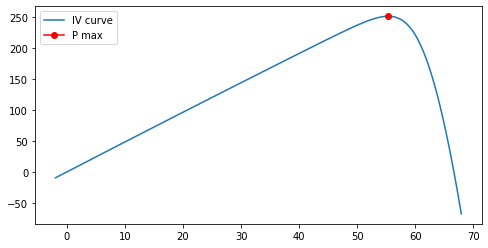

In [15]:
def plot_pv_curve_m(iv_df):
    
    p_max, i_max, v_max = get_ivmax(iv_df)
    
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    filter = (iv_df["v"]>-2)
    plt.plot(iv_df.loc[filter, "v"], iv_df.loc[filter,"p"], label="IV curve")
    plt.plot(v_max, p_max, color="red", marker="o", label="P max")
    plt.legend() # Show the labels
    
    return ax

_ = plot_pv_curve_m(iv_df)

### Exercice: Diode Bypass effect

Add the effect of three (ideal) bypass diodes with a breakdown voltage equal to 0.5 V on the IV dataframe

*Hints:* Change the voltage values straight to -1.5 V for all the rows with voltage under -1.5V,. The "clip()" method can be used.

In [16]:
def iv_curve_wdiode(G, T):
    i_l, i_0, r_s, r_sh, a = calcparams_desoto(G, T,  alpha_sc, a_ref, I_L_ref, I_o_ref, R_sh_ref, R_s)

    # Prepare the voltage range
    i_range = np.arange(-1, 10, 0.0001)
    v_range = v_from_i(i_range, i_l, i_0, r_s, r_sh,a)

    # Store 
    iv_df = pd.DataFrame()
    iv_df["i"] = i_range
    iv_df["v"] = v_range
    
    # Assigne -1.5 V to the "v" column for all rows which have a voltage under 1.5V
    filter_v= (iv_df["v"]<-1.5)
    iv_df.loc[filter_v, "v"] = -1.5
    
    return iv_df

iv_df = iv_curve_wdiode(800, 40)

251.69650463775363 4.548899999999389 55.33128990256709


<AxesSubplot:>

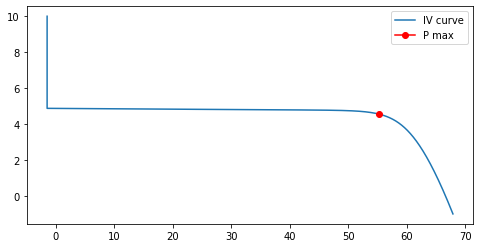

In [17]:
p_max, i_max, v_max = get_ivmax(iv_df)
print(p_max, i_max, v_max)

plot_iv_curve_m(iv_df)

### Exercice: IV-curve at the array level

Combine the IV curves of 12 modules connected in series. The Voltages should be summed up.

Plot the IV curve at the array level.

*Hints:*
1. Create an empty DataFrame.
2. Fills the "i" column with the i_index.
3. Fills the "v" column with 0s.
4. Create a loop to go through the 12 modules and adds up the voltage in the "v" column.

In [18]:
### Here is some function to combine IV curves for modules in series
def combine_series(dfs: list, i_range: list):
    """
    dfs: expect a list, list of IV curves (pd.DataFrame)
    i_range: expect a list, list of current index
    
    Combine IV curves in series by aligning currents and summing voltages.
    
    Dfs should EXACTLY have the same current in their "i" column !
    """

    iv_all = pd.DataFrame(columns=["i", "v"])
    iv_all["i"] = i_range
    iv_all["v"] = 0
    for df in dfs:
        iv_all["v"] = iv_all["v"] + df["v"]

    return iv_all

In [19]:
dfs = [iv_df for i in range(12)]

iv_all = combine_series(dfs, i_range)

p_max_s, i_max_s, v_max_s = get_ivmax(iv_all)
print(iv_all)
print(p_max_s, i_max_s, v_max_s)

             i           v           p
0      -1.0000  814.998501 -814.998501
1      -0.9999  814.997023 -814.915524
2      -0.9998  814.995546 -814.832547
3      -0.9997  814.994069 -814.749571
4      -0.9996  814.992591 -814.666594
...        ...         ...         ...
109995  9.9995  -18.000000 -179.991000
109996  9.9996  -18.000000 -179.992800
109997  9.9997  -18.000000 -179.994600
109998  9.9998  -18.000000 -179.996400
109999  9.9999  -18.000000 -179.998200

[110000 rows x 3 columns]
3020.3580556530433 4.548899999999389 663.9754788308051


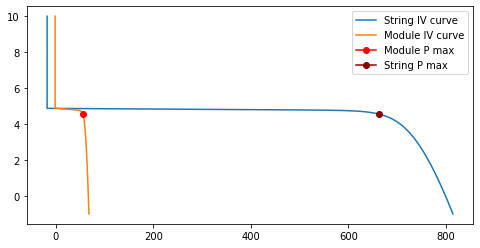

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

# IV curves
plt.plot(iv_all["v"], iv_all["i"], label="String IV curve")
plt.plot(iv_df["v"], iv_df["i"], label="Module IV curve")

# Show Pmpp values
plt.plot(v_max, i_max, color="red", marker="o", label="Module P max")
plt.plot(v_max_s, i_max_s, color="darkred", marker="o", label="String P max")

plt.legend() # Show the labels

### Exercice to go further: Shading

Let's assume that one of the twelve modules is shaded and it only gets 300 W/m2 instead of 800 W/m2 and the module temperature is at 20 degrees Celsius.

Reconstruct the IV curve at the array level.

***Hints:***
- Recalculate the IV for 300 W/m2 in a new DataFrame.
- Create a loop to go through the 11 modules and adds up the voltage in the "v" column.
- Add up the voltage of the shaded module.

             i          v
0      -1.0000  69.461294
1      -0.9999  69.461131
2      -0.9998  69.460967
3      -0.9997  69.460803
4      -0.9996  69.460639
...        ...        ...
109995  9.9995  -1.500000
109996  9.9996  -1.500000
109997  9.9997  -1.500000
109998  9.9998  -1.500000
109999  9.9999  -1.500000

[110000 rows x 2 columns]


<AxesSubplot:>

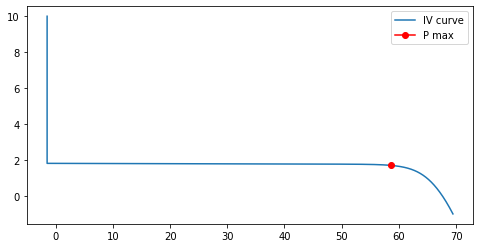

In [21]:
iv_df_shaded = iv_curve_wdiode(300, 20)
print(iv_df_shaded)

plot_iv_curve_m(iv_df_shaded)

In [22]:
def combine_series_shaded(dfs: list, shaded_m: pd.DataFrame, i_range: list):
    """
    dfs: expect a list, list of IV curves (pd.DataFrame)
    shaded_m: pd.DataFrame of the shaded module
    i_range: expect a list, list of current index
    
    Combine IV curves in series by aligning currents and summing voltages.
    
    Dfs should EXACTLY have the same current !
    """

    iv_all_shaded = pd.DataFrame(columns=["i", "v"])
    iv_all_shaded["i"] = i_range
    iv_all_shaded["v"] = 0
    for df in dfs:
        iv_all_shaded["v"] = iv_all_shaded["v"] + df["v"]
        
    iv_all_shaded["v"] = iv_all_shaded["v"] + shaded_m["v"]

    return iv_all_shaded

In [23]:
dfs = [iv_df for i in range(11)]
iv_all_shaded = combine_series_shaded(dfs, iv_df_shaded, i_range)

Pmax without shading: 3020 W
Pmax with shading: 2762 W


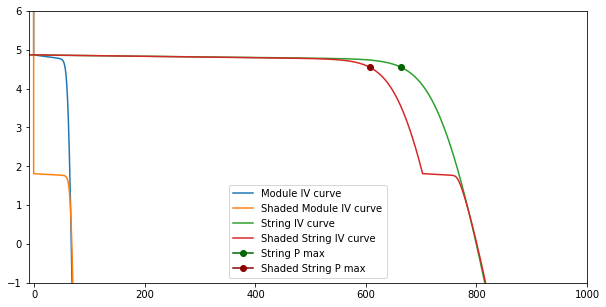

In [24]:
# Calculate Pmpps
p_max_s, i_max_s, v_max_s = get_ivmax(iv_all)
p_max_shaded, i_max_s_shaded, v_max_s_shaded = get_ivmax(iv_all_shaded)

fig, ax = plt.subplots(1, 1, figsize=(10,5))

# IV curves at module level
plt.plot(iv_df["v"], iv_all["i"], label="Module IV curve")
plt.plot(iv_df_shaded["v"], iv_df_shaded["i"], label="Shaded Module IV curve")

# IV curves at string level
plt.plot(iv_all["v"], iv_all["i"], label="String IV curve")
plt.plot(iv_all_shaded["v"], iv_all_shaded["i"], label="Shaded String IV curve")

# Show Pmpps
plt.plot(v_max_s, i_max_s, color="darkgreen", marker="o", label="String P max")
plt.plot(v_max_s_shaded, i_max_s_shaded, color="darkred", marker="o", label="Shaded String P max")
plt.legend() # Show the labels

plt.xlim([-10, 1000])
plt.ylim([-1, 6])

print(f"Pmax without shading: {round(p_max_s)} W")
print(f"Pmax with shading: {round(p_max_shaded)} W")

# II. Accurate DC power estimation

Here below is an example to perform a regression with the non-linear least squares method from scipy "curve_fit"

[ 2.01486001e+00 -6.40941216e-03  1.83269209e+02]


<AxesSubplot:>

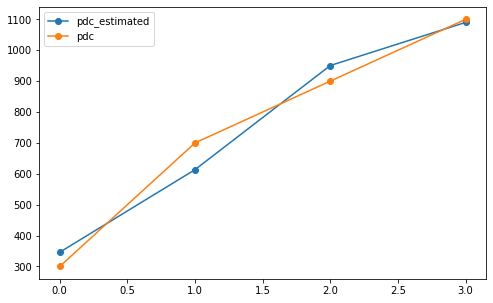

In [25]:
# A function needs to be defined first
# The first argument includes all variables, then the other arguments are the coefficients to optimize
def func(x, a, b, c):
    g_poa, t_mod = x
    power = a * g_poa  * (1 + b * t_mod) + c
    return power

# Build some (fake) training set
df = pd.DataFrame(columns=["g_poa","t_mod","pdc"])
df.loc[0] =[100, 30, 300]
df.loc[1] = [300, 45, 700]
df.loc[2] = [600, 57, 900]
df.loc[3] = [900, 78, 1100]

# Prepare inputs for "curve_fit"
x_train = df[["g_poa","t_mod"]].T.values # T. for transpose (training values)
y_train = df["pdc"].values # Target

# Find the optimal coefficients by minimizing the error root square on the training set
popt, pcov = curve_fit(func,x_train, y_train)

# Print the optimal coefficients
print(popt)

# Apply the optimal coefficents on the training set and store it in the DataFrame
estimation = func(x_train, popt[0], popt[1], popt[2])
df["pdc_estimated"] = estimation

# Plot the estimated and actual values
fig, ax = plt.subplots(1,1, figsize=(8,5)) 
df[["pdc_estimated", "pdc"]].plot(ax=ax, marker="o")

Below is the weather inputs of the models to estimate the DC production. 

Insitu measurements are imported in this section by executing the cell below.

g_poa: Plane-Of-Array irradiance [W/m²]

t_mod: Module Temperature [°C]

pdc: DC power [W]

In [26]:
# Load actual data
url = "https://raw.githubusercontent.com/AlexandreHugoMathieu/pvfault_detection_solar_academy/refs/heads/master/data/ytrain.csv"
actual = pd.read_csv(url, index_col=0) 
actual.index = pd.to_datetime(actual.index)
print(actual.head(10))

                                 gpoa      t_mod          pdc
2020-01-01 01:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 02:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 03:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 04:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 05:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 06:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 07:00:00-07:00    0.000000   0.000000     0.000000
2020-01-01 08:00:00-07:00   26.144398  -7.713991   284.904857
2020-01-01 09:00:00-07:00  441.739142   5.177106  1481.974075
2020-01-01 10:00:00-07:00  700.841725  15.212283  2690.471151


#### Exercice: 1-diode 5-parameters over a year

Use the irradiance and module temperature values as inputs to estimate the maximum power point for all timesteps according to the IV-modeling approach seen in section I.

*Hint* 

Create a loop over all timesteps and reexecute the commands from section I.

In [27]:
desoto_df = pd.DataFrame(index=actual.index, data=0, columns=["p_dc","i_dc","v_dc"])

for idx, row in tqdm(actual.iterrows(), total=len(actual.index)):
    if row["gpoa"]>0:
        iv_module = iv_curve_wdiode(row["gpoa"], row["t_mod"])
        
        # Combine IV curves at the string level
        dfs = [iv_module for i in range(12)]
        iv_all = combine_series(dfs, i_range)
        
        # Get the maximum power point
        p_max_s, i_max_s, v_max_s = get_ivmax(iv_all)
        
        # Store the values
        desoto_df.loc[idx, "p_dc"] = p_max_s
        desoto_df.loc[idx, "i_dc"] = i_max_s
        desoto_df.loc[idx, "v_dc"] = v_max_s

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8760/8760 [05:04<00:00, 28.79it/s]


In [31]:
print(desoto_df.head(24))

                                  p_dc    i_dc        v_dc
2020-01-01 01:00:00-07:00     0.000000  0.0000    0.000000
2020-01-01 02:00:00-07:00     0.000000  0.0000    0.000000
2020-01-01 03:00:00-07:00     0.000000  0.0000    0.000000
2020-01-01 04:00:00-07:00     0.000000  0.0000    0.000000
2020-01-01 05:00:00-07:00     0.000000  0.0000    0.000000
2020-01-01 06:00:00-07:00     0.000000  0.0000    0.000000
2020-01-01 07:00:00-07:00     0.000000  0.0000    0.000000
2020-01-01 08:00:00-07:00   105.291157  0.1464  719.201891
2020-01-01 09:00:00-07:00  1836.434706  2.4842  739.245917
2020-01-01 10:00:00-07:00  2833.486156  3.9521  716.957100
2020-01-01 11:00:00-07:00  3478.033148  4.9643  700.608978
2020-01-01 12:00:00-07:00  3766.016001  5.5356  680.326613
2020-01-01 13:00:00-07:00  3531.820548  5.2320  675.042154
2020-01-01 14:00:00-07:00  3121.041282  4.5356  688.120928
2020-01-01 15:00:00-07:00  2363.999981  3.3499  705.692701
2020-01-01 16:00:00-07:00   839.212639  1.1604  723.2097

#### Exercice: Accuracy

Compare the accuracy with the DC PVwatts model when the irradiance is over 0 W/m²:

- Mean Biais in W and % with the model as reference.
- Mean Absolute Biais in W.

In [28]:
# Classic approach
Pdc_0 = 12*325 # Wp Nominal power
gamma_pdc= -0.258/100 # [-]/°C

def pvwatts_dc(poa_global, t_mod, Pdc_0, gamma_pdc):
    dc_power = Pdc_0 * poa_global / 1000 * (1 + gamma_pdc * (t_mod - 25)) 
    return dc_power

dc_power = pvwatts_dc(actual["gpoa"], actual["t_mod"], Pdc_0, gamma_pdc)

In [44]:
filter = (actual["gpoa"]>5) & (actual["pdc"]>5)

residuals_desoto = (actual["pdc"] - desoto_df["p_dc"]).loc[filter]
me_desoto = residuals_desoto.mean()
mae_desoto = residuals_desoto.abs().mean()

residuals_pvwatts = (actual["pdc"] - dc_power).loc[filter]
me_pvwatts = residuals_pvwatts.mean()
mae_pvwatts = residuals_pvwatts.abs().mean()

print(f"ME DeSoto: {round(me_desoto,1)} W")
total = desoto_df.loc[filter,"p_dc"].mean()
print(f"ME DeSoto: {round(me_desoto/total*100,1)} %") # % according to model values
print(f"MAE DeSoto: {round(mae_desoto,1)} W")

print("\n")

print(f"ME PVWatts: {round(me_pvwatts,1)} W")
print(f"ME PVWatts: {round(me_pvwatts/dc_power.loc[filter].mean()*100,1)} %") # % according to model values
print(f"MAE PVWatts: {round(mae_pvwatts,1)} W")

ME DeSoto: -129.3 W
ME DeSoto: -6.7 %
MAE DeSoto: 131.1 W


ME PVWatts: -122.1 W
ME PVWatts: -6.4 %
MAE PVWatts: 123.7 W


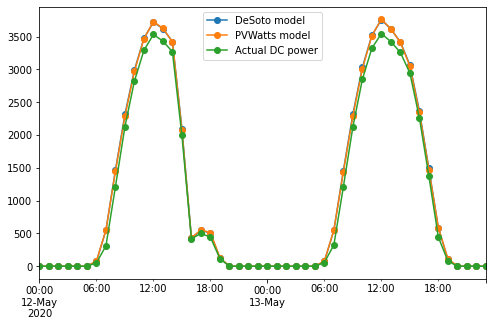

In [46]:
# Create a new figure with plt.subplots
fig, ax = plt.subplots(1,1, figsize=(8,5)) 

desoto_df.loc["20200512":"20200513", "p_dc"].plot(ax=ax, label="DeSoto model", marker="o")
dc_power.loc["20200512":"20200513"].plot(ax=ax, label="PVWatts model", marker="o")
actual.loc["20200512":"20200513", "pdc"].plot(ax=ax, label="Actual DC power", marker="o")

plt.legend()

#### Exercise: Error distribution

- Plot the error distribution for both models.

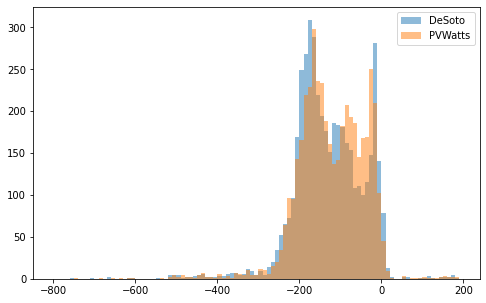

In [47]:
fig, ax = plt.subplots(1,1, figsize=(8,5)) 
_ = plt.hist(residuals_desoto, alpha=0.5, bins=np.arange(-800,200,10), label="DeSoto")
_ = plt.hist(residuals_pvwatts, alpha=0.5, bins=np.arange(-800,200,10), label="PVWatts")
plt.legend()

### Model improvement

Two ways to improve the initial estimation are shown in the following cells:

1. Add a term to the first estimation based on residual analysis
2. Perform regression on the DC PVWatts coefficients Pdc0 and the thermal coefficient gamma_pdc


#### Exercice: Improved Single Diode model 

Adjust the initial estimation in a new pd.Series with the single diode model by adding it the mean residual error.

In [51]:
residual_me_ratio = residuals_desoto.mean()/desoto_df.loc[filter, "p_dc"].mean()

desoto_v2 = desoto_df["p_dc"] * (1+residual_me_ratio)

filter = (actual["gpoa"]>5) & (actual["pdc"]>5)

residuals_desoto_v2 = (actual["pdc"] - desoto_v2).loc[filter]
me_desoto_v2 = residuals_desoto_v2.mean()
mae_desoto_v2 = residuals_desoto_v2.abs().mean()

print(f"ME DeSoto: {round(me_desoto_v2,1)} W")
total = desoto_df.loc[filter,"p_dc"].mean()
print(f"ME DeSoto: {round(me_desoto_v2/total*100,1)} %")
print(f"MAE DeSoto: {round(mae_desoto_v2,1)} W")

ME DeSoto: 0.0 W
ME DeSoto: 0.0 %
MAE DeSoto: 61.6 W


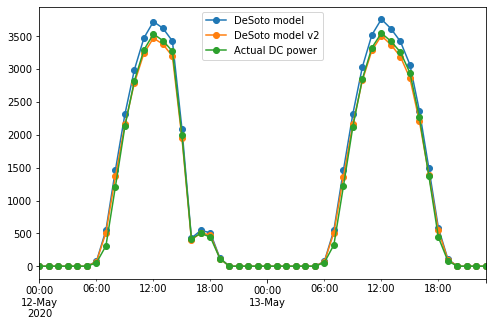

In [54]:
# Create a new figure with plt.subplots
fig, ax = plt.subplots(1,1, figsize=(8,5)) 

desoto_df.loc["20200512":"20200513", "p_dc"].plot(ax=ax, label="DeSoto model", marker="o")
desoto_v2.loc["20200512":"20200513"].plot(ax=ax, label="DeSoto model v2", marker="o")
actual.loc["20200512":"20200513", "pdc"].plot(ax=ax, label="Actual DC power", marker="o")

plt.legend()

In [55]:
# The PVWatts function to optimize
def pvwatts_dc_opt(x, Pdc_0, gamma_pdc):
    poa_global, t_mod = x
    dc_power = Pdc_0 * poa_global / 1000 * (1 + gamma_pdc * (t_mod - 25)) 
    return dc_power

# Prepare inputs for "curve_fit"
x_train = actual[["gpoa","t_mod"]].T.values # T. for transpose (training values)
y_train = actual["pdc"].values # Target

# Find the optimal coefficients by minimizing the error root square on the training set
popt, pcov = curve_fit(pvwatts_dc_opt,x_train, y_train)

# Print the optimal 
print(popt)

[3.37564561e+03 1.44704657e-03]


In [56]:
Pdc_0_v2 = popt[0]
gamma_pdc_v2 =  popt[1]

dc_power_v2 = pvwatts_dc(actual["gpoa"], actual["t_mod"], Pdc_0_v2, gamma_pdc_v2)

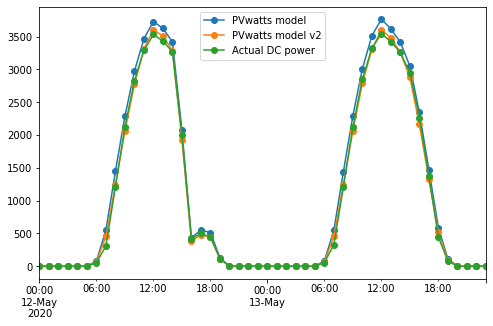

In [57]:
# Create a new figure with plt.subplots
fig, ax = plt.subplots(1,1, figsize=(8,5)) 

dc_power.loc["20200512":"20200513"].plot(ax=ax, label="PVwatts model", marker="o")
dc_power_v2.loc["20200512":"20200513"].plot(ax=ax, label="PVwatts model v2", marker="o")
actual.loc["20200512":"20200513", "pdc"].plot(ax=ax, label="Actual DC power", marker="o")

plt.legend()

In [58]:
filter = (actual["gpoa"]>5) & (actual["pdc"]>5)

residuals_pvwatts_v2 = (actual["pdc"] - dc_power_v2).loc[filter]
me_pvwatts_v2 = residuals_pvwatts_v2.mean()
mae_pvwatts_v2 = residuals_pvwatts_v2.abs().mean()

print(f"ME PVWatts: {round(me_pvwatts_v2,1)} W")
print(f"ME PVWatts: {round(me_pvwatts_v2/actual.loc[filter, 'pdc'].mean()*100,1)} %")
print(f"MAE PVWatts: {round(mae_pvwatts_v2,1)} W")

ME PVWatts: 37.5 W
ME PVWatts: 2.1 %
MAE PVWatts: 94.4 W


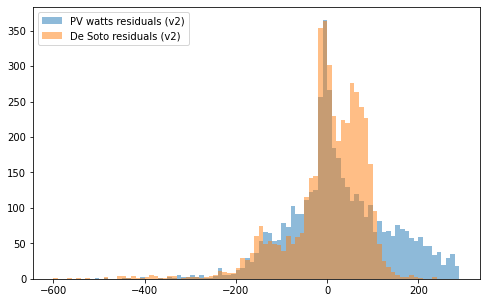

In [60]:
fig, ax = plt.subplots(1,1, figsize=(8,5)) 
_ = plt.hist(residuals_pvwatts_v2, bins=np.arange(-600,300,10), alpha=0.5, label="PV watts residuals (v2)")
_ = plt.hist(residuals_desoto_v2, bins=np.arange(-600,300,10), alpha=0.5, label="De Soto residuals (v2)")
plt.legend()

#### Exercice: Failure detection

- Define a threshold in W from the residual analysis to identify when the system underperforms compare to one of the estimate.
- Create a filter to detect failure/underperformances based on this threshold
- Create a new pd.Series with the same index as actual which includes the detected energy losses

In [62]:
# From the plot above, the uncertainty band ranges roughly from -300 W to +200W
# Then when the actuals are under than -200 W, the system is considered to underperform.
threshold = 200

failure_detection = (actual["pdc"] < (desoto_v2 - threshold))

energy_loss=pd.Series(data=0., index=actual.index)
energy_loss.loc[failure_detection] = (desoto_v2 - actual["pdc"]).clip(lower=0)

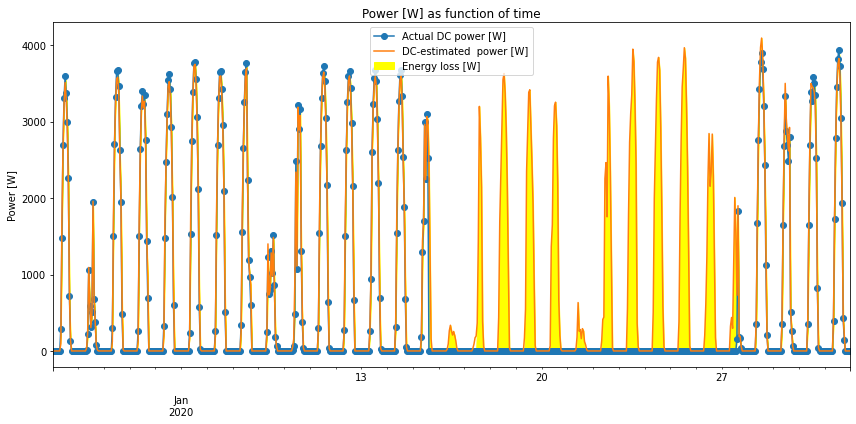

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))

filter = (actual.index.month==1)  & (actual.index.year==2020)

actual.loc[filter,"pdc"].plot(ax=ax, title="Power [W] as function of time", marker="o",
                              ylabel="Power [W]", label="Actual DC power [W]")
desoto_v2.loc[filter].plot(ax=ax, label="DC-estimated  power [W]")


plt.fill_between(actual.loc[filter].index, actual.loc[filter, "pdc"], 
                 (actual.loc[filter, "pdc"] + energy_loss.loc[filter]), 
                 color="yellow", label="Energy loss [W]")
plt.legend()
plt.tight_layout()